In [1]:
from chessnet.notebook_config import *

In [20]:
graphs = {
    "OTB": read_pickle("OM_OTB_201609", directed=False),
    "Portal": read_pickle("OM_Portal_201510", directed=False),
}
for name, g in graphs.items():
    meank = np.mean(g.degree())
    meank2 = np.mean(np.power(g.degree(), 2))
    print(name, g.summary(), meank, meank2 / meank)

OTB IGRAPH UN-- 198494 3874277 -- 
+ attr: MeanElo (v), StdElo (v), name (v), NUMBER_OF_GAMES (e) 39.03671647505718 234.76480463322574
Portal IGRAPH UN-- 212875 7594313 -- 
+ attr: MeanElo (v), StdElo (v), name (v), NUMBER_OF_GAMES (e) 71.34997533763946 1200.391529556393


In [3]:
graphs_FV = {
    "OTB": read_randomized_edgelist("OM_OTB_201609", mode="fabien-viger"),
    "Portal": read_randomized_edgelist("OM_Portal_201510", mode="fabien-viger"),
}
for name, g in graphs_FV.items():
    print(name, g.summary())

OTB IGRAPH U--- 198494 3874277 -- 
Portal IGRAPH U--- 212875 7594313 -- 


In [7]:
nswap_ecount_times = 10.0
graphs_rewired = {
    "OTB": read_rewired_graph("OM_OTB_201609", nswap_ecount_times=nswap_ecount_times),
    "Portal": read_rewired_graph("OM_Portal_201510", nswap_ecount_times=nswap_ecount_times),
}
for name, g in graphs_rewired.items():
    print(name, g.summary())

OTB IGRAPH UN-- 198494 3874277 -- 
+ attr: MeanElo (v), StdElo (v), _nx_name (v), name (v)
Portal IGRAPH UN-- 212875 7594313 -- 
+ attr: MeanElo (v), StdElo (v), _nx_name (v), name (v), NUMBER_OF_GAMES (e)


In [5]:
dfs = {}
for name, g in graphs.items():
    df = pd.DataFrame({
        "k": g.degree(),
        "Cws": g.transitivity_local_undirected(mode="zero"),
        "knn": g.knn()[0],
    })
    dfs[name] = df

In [6]:
dfs_FV = {}
for name, g in graphs_FV.items():
    df = pd.DataFrame({
        "k": g.degree(),
        "Cws": g.transitivity_local_undirected(mode="zero"),
        "knn": g.knn()[0],
    })
    dfs_FV[name] = df
del graphs_FV

In [7]:
dfs_rewired = {}
for name, g in graphs_rewired.items():
    df = pd.DataFrame({
        "k": g.degree(),
        "Cws": g.transitivity_local_undirected(mode="zero"),
        "knn": g.knn()[0],
    })
    dfs_rewired[name] = df
del graphs_rewired

In [11]:
def plot_degree_distribution(data, ax=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots()
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$p_k$")
    # Log scale
    bins = np.logspace(np.log10(min(data)), np.log10(max(data)+1), 20)
    freq, _ = np.histogram(data, bins=bins, density=True)
    X_log, Y_log = bins[:-1], freq

    Y_pred, slope, y_err = linear_regression(X_log[:-3], Y_log[:-3])
    c = Y_log[5] / X_log[5]**slope
    #label = r'$\gamma = {{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
    label = r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
    #ax.text(0.45, 0.73, label, fontsize=26, transform=ax.transAxes)
    ax.text(0.28, 0.5, r"$\gamma = -1.5$", fontsize=26, transform=ax.transAxes)
    #ax.plot(
    #    X_log, powerlaw(X_log, slope, c), "--", color="k", zorder=10, #label=label,
    #)

    #X_powerlaw = X_log
    X_powerlaw = np.array([1, 10000])
    ax.plot(
        X_powerlaw, powerlaw(X_powerlaw, -1.5, c), "--", color="k", zorder=10, #label=label,
    )

    # Lin scale
    bins = range(1, max(data)+1)
    freq, _ = np.histogram(data, bins=bins, density=True)
    X_lin, Y_lin = bins[:-1], freq

    ax.plot(
        X_lin,
        Y_lin,
        ".",
        color="gray",
        alpha=0.5,
        fillstyle="none",
        label="Bineado lineal"
    )
    color = kwargs.get("color")
    ax.plot(
        X_log,
        Y_log,
        "o",
        markersize=10,
        color=color,
        label="Bineado logarítmico"
    )
    return ax

def plot_avg_clustering_by_degree(df, ax=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots()
    ax.set_xscale("log")
    ax.set_yscale("log")

    grouped = df.groupby(by="k")["Cws"].mean()
    X = grouped.index
    Y = grouped.values
    marker = kwargs.get("marker", "o")
    fillstyle = kwargs.get("fillstyle", "full")
    label = kwargs.get("label")
    color = kwargs.get("color")
    ax.plot(X, Y, marker, fillstyle=fillstyle, label=label, color=color)
    return ax

def plot_knn_by_degree(df, ax=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots()
    ax.set_xscale("log")

    grouped = df.groupby(by="k")["knn"].mean()
    X = grouped.index
    Y = grouped.values
    marker = kwargs.get("marker", "o")
    fillstyle = kwargs.get("fillstyle", "full")
    label = kwargs.get("label")
    color = kwargs.get("color")
    ax.plot(X, Y, marker, fillstyle=fillstyle, label=label, color=color)
    return ax

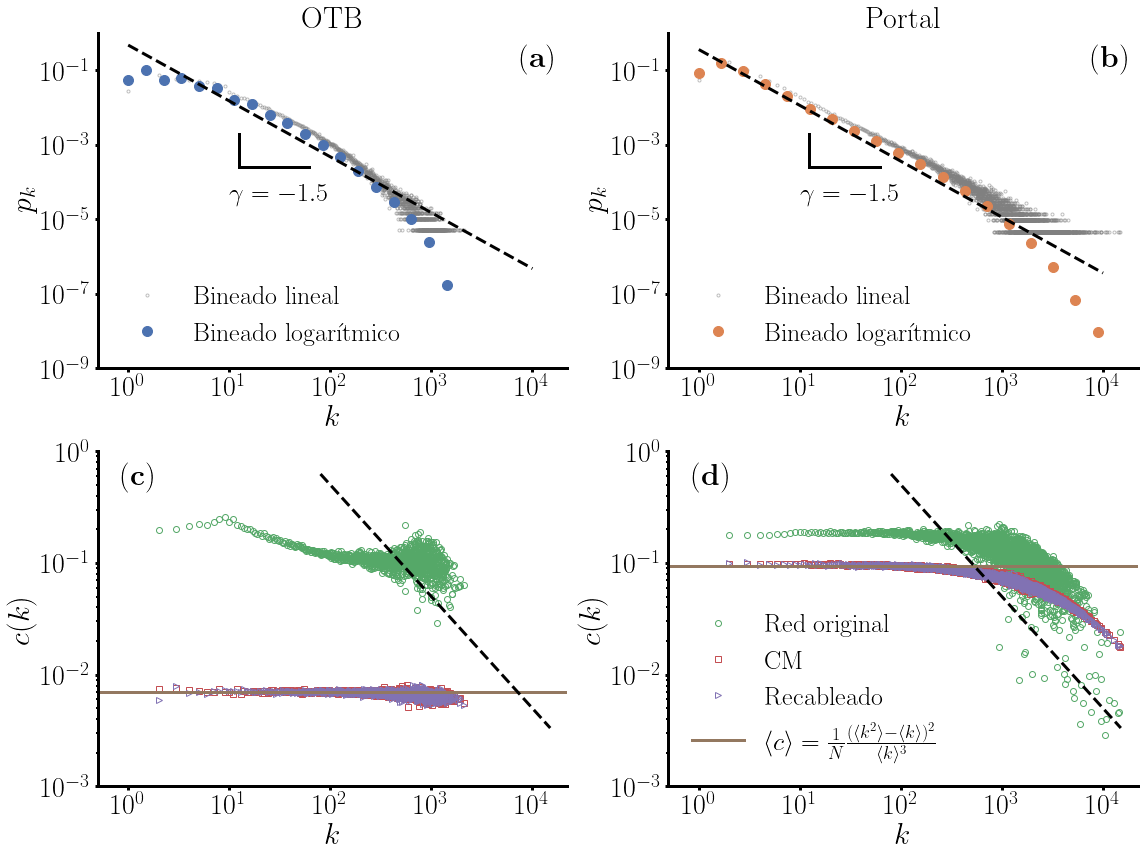

In [12]:
maxk = max([max(g.degree()) for g in graphs.values()])

ncols = 2
nrows = 2
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
for ax in axes.flatten():
    ax.set_xlim(0.5, 1.5*maxk)
axes[0,0].set_title(database_latex["OTB"], fontsize=30)
axes[0,1].set_title(database_latex["Portal"], fontsize=30)
axes[0,0].plot([0.3, 0.45], [0.6, 0.6], "-", color="k", transform=axes[0,0].transAxes)
axes[0,0].plot([0.3, 0.3], [0.6, 0.7], "-", color="k", transform=axes[0,0].transAxes)
axes[0,1].plot([0.3, 0.45], [0.6, 0.6], "-", color="k", transform=axes[0,1].transAxes)
axes[0,1].plot([0.3, 0.3], [0.6, 0.7], "-", color="k", transform=axes[0,1].transAxes)
for i, (name, df) in enumerate(dfs.items()):
    
    ax = axes[0,i]
    ax.text(0.9, 0.9, panels[i], fontsize=30, transform=ax.transAxes)
    plot_degree_distribution(df["k"], ax=ax, color=f"C{i}")
    ax.set_xticks([1, 10, 100, 1000, 10000])
    ax.set_ylim(1e-9, 1)

    ax = axes[1,i]
    ax.text(0.05, 0.9, panels[2+i], fontsize=30, transform=ax.transAxes)
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$c(k)$")
    plot_avg_clustering_by_degree(
        df, ax=ax, fillstyle="none", label="Red original", color="C2"
    )
    ax.set_xticks([1, 10, 100, 1000, 10000])
    ax.set_ylim(1e-3, 1)

for i, (name, df) in enumerate(dfs_FV.items()):
    ax = axes[1,i]
    label = "CM"
    plot_avg_clustering_by_degree(
        df, ax=ax, marker="s", fillstyle="none", label=label, color="C3"
    )

for i, (name, df) in enumerate(dfs_rewired.items()):
    ax = axes[1,i]
    label = "Recableado"
    plot_avg_clustering_by_degree(
        df, ax=ax, marker=">", fillstyle="none", label=label, color="C4"
    )
    meank = df.k.mean()
    meank2 = (df.k**2).mean()
    N = len(df)
    xline = (1/N) * (meank2 - meank)**2 / meank**3
    label = r"$\langle c \rangle = \frac{1}{N} \frac{(\langle k^2\rangle - \langle k\rangle)^2}{\langle k \rangle^3}$"
    ax.axhline(xline, color="C5", label=label)

    X = np.array([80., 15000.])
    Y = powerlaw(X, -1, 50)
    ax.plot(X, Y, linestyle="--", color="k")
    ax.set_xticks([1, 10, 100, 1000, 10000])

axes[0,0].legend(frameon=False)
axes[0,1].legend(frameon=False)
axes[1,1].legend(frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig(FIGS_DIR / "pk_and_ck.pdf")
plt.show()

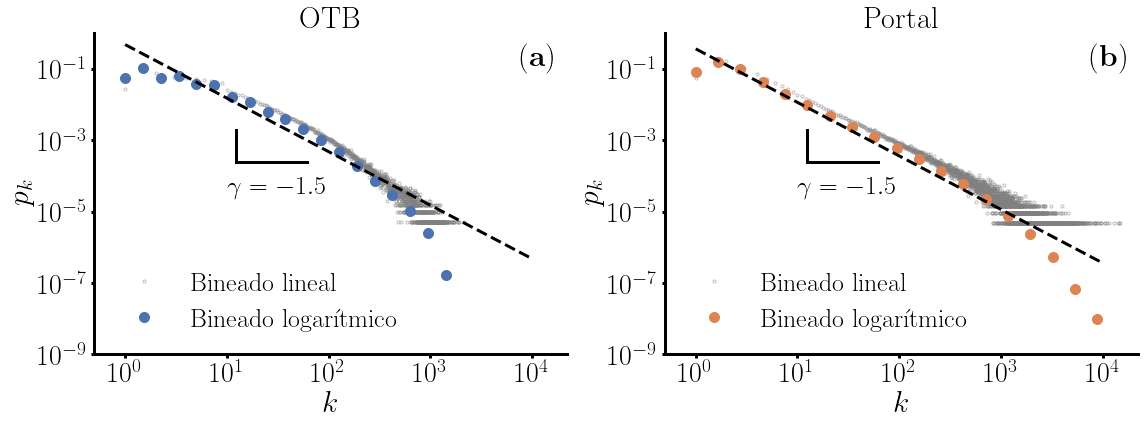

In [17]:
maxk = max([max(g.degree()) for g in graphs.values()])

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
for ax in axes.flatten():
    ax.set_xlim(0.5, 1.5*maxk)
axes[0].set_title(database_latex["OTB"], fontsize=30)
axes[1].set_title(database_latex["Portal"], fontsize=30)
axes[0].plot([0.3, 0.45], [0.6, 0.6], "-", color="k", transform=axes[0].transAxes)
axes[0].plot([0.3, 0.3], [0.6, 0.7], "-", color="k", transform=axes[0].transAxes)
axes[1].plot([0.3, 0.45], [0.6, 0.6], "-", color="k", transform=axes[1].transAxes)
axes[1].plot([0.3, 0.3], [0.6, 0.7], "-", color="k", transform=axes[1].transAxes)
for i, (name, df) in enumerate(dfs.items()):

    ax = axes[i]
    ax.text(0.9, 0.9, panels[i], fontsize=30, transform=ax.transAxes)
    plot_degree_distribution(df["k"], ax=ax, color=f"C{i}")
    ax.set_xticks([1, 10, 100, 1000, 10000])
    ax.set_ylim(1e-9, 1)

axes[0].legend(frameon=False)
axes[1].legend(frameon=False)

sns.despine()
plt.tight_layout()
plt.savefig(FIGS_DIR / "pk.pdf")
plt.show()

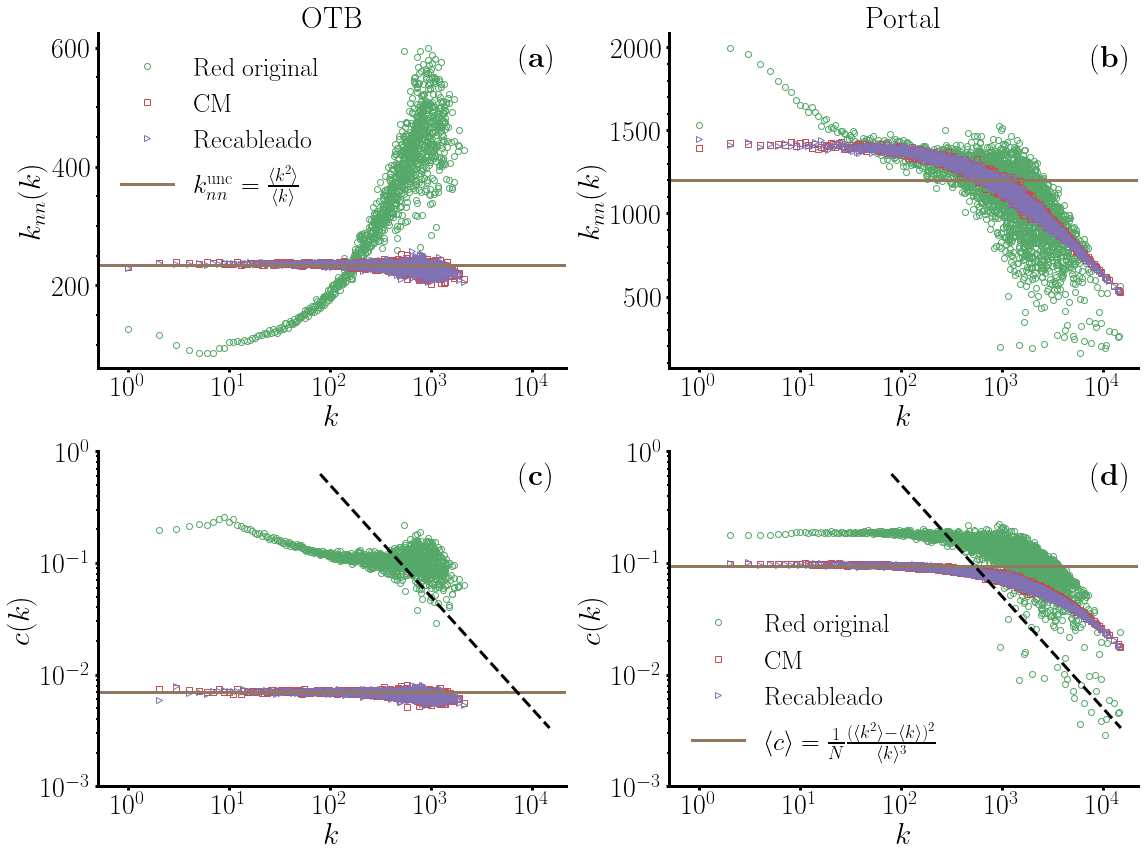

In [ ]:
maxk = max([max(g.degree()) for g in graphs.values()])

ncols = 2
nrows = 2
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
axes[0,0].set_title(database_latex["OTB"], fontsize=30)
axes[0,1].set_title(database_latex["Portal"], fontsize=30)

for i, (name, df) in enumerate(dfs.items()):
    ax = axes[1,i]
    ax.text(0.9, 0.9, panels[2+i], fontsize=30, transform=ax.transAxes)
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$c(k)$")
    plot_avg_clustering_by_degree(
        df, ax=ax, fillstyle="none", label=r"$\mathrm{Red\;original}$", color="C2"
    )
    ax.set_ylim(1e-3, 1)

    ax = axes[0,i]
    ax.text(0.9, 0.9, panels[i], fontsize=30, transform=ax.transAxes)
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$k_{nn}(k)$")
    plot_knn_by_degree(
        df, ax=ax, fillstyle="none", label=r"$\mathrm{Red\;original}$", color="C2"
    )

for i, (name, df) in enumerate(dfs_FV.items()):
    ax = axes[1,i]
    label = r"$\mathrm{CM}$"
    plot_avg_clustering_by_degree(
        df, ax=ax, marker="s", fillstyle="none", label=label, color="C3"
    )
    ax = axes[0,i]
    label = r"$\mathrm{CM}$"
    plot_knn_by_degree(
        df, ax=ax, marker="s", fillstyle="none", label=label, color="C3"
    )

for i, (name, df) in enumerate(dfs_rewired.items()):
    ax = axes[1,i]
    label = r"$\mathrm{Recableado}$"
    plot_avg_clustering_by_degree(
        df, ax=ax, marker=">", fillstyle="none", label=label, color="C4"
    )
    meank = df.k.mean()
    meank2 = (df.k**2).mean()
    N = len(df)
    xline = (1/N) * (meank2 - meank)**2 / meank**3
    label = r"$\langle c \rangle = \frac{1}{N} \frac{(\langle k^2\rangle - \langle k\rangle)^2}{\langle k \rangle^3}$"
    ax.axhline(xline, color="C5", label=label)

    X = np.array([80., 15000.])
    Y = powerlaw(X, -1, 50)
    ax.plot(X, Y, linestyle="--", color="k")

    ax = axes[0,i]
    label = r"$\mathrm{Recableado}$"
    plot_knn_by_degree(
        df, ax=ax, marker=">", fillstyle="none", label=label, color="C4"
    )

    xline = meank2 / meank
    label = r"$k_{nn}^{\mathrm{unc}} =  \frac{\langle k^2\rangle }{\langle k \rangle}$"
    ax.axhline(xline, color="C5", label=label)

for ax in axes.flatten():
    ax.set_xlim(0.5, 1.5*maxk)
    ax.set_xticks([1, 10, 100, 1000, 10000])

axes[0,0].legend(frameon=False)
#axes[0,1].legend(frameon=False)
axes[1,1].legend(frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig(FIGS_DIR / "knn_and_ck.pdf")
plt.show()

### Asortatividad

In [11]:
for name in ["OTB", "Portal"]:
    print(
        name,
        np.round(
            np.array([
                graphs[name].assortativity_degree(),
                graphs_FV[name].assortativity_degree(),
                graphs_rewired[name].assortativity_degree()
            ]),
        3),
        sep="\t"
    )

OTB	[ 0.359 -0.01  -0.01 ]
Portal	[-0.118 -0.095 -0.095]


### Asortatividad por Elo

In [18]:
for name in ["OTB", "Portal"]:
    print(
        name,
        np.round(
            np.array([
                graphs[name].assortativity("MeanElo"),
                #graphs_FV[name].assortativity("MeanElo"),
                graphs_rewired[name].assortativity("MeanElo"),
            ]),
        3),
        sep="\t"
    )

OTB	[ 0.693 -0.004]
Portal	[0.557 0.   ]


### C

In [15]:
for name in ["OTB", "Portal"]:
    print(
        name,
        np.round(
            np.array([
                graphs[name].transitivity_undirected(),
                graphs_FV[name].transitivity_undirected(),
                graphs_rewired[name].transitivity_undirected()
            ]),
        3),
        sep="\t"
    )

OTB	[0.106 0.007 0.007]
Portal	[0.086 0.055 0.055]


### C_WS

In [16]:
for name in ["OTB", "Portal"]:
    print(
        name,
        np.round(
            np.array([
                graphs[name].transitivity_avglocal_undirected(),
                graphs_FV[name].transitivity_avglocal_undirected(),
                graphs_rewired[name].transitivity_avglocal_undirected()
            ]),
        3),
        sep="\t"
    )

OTB	[0.188 0.007 0.007]
Portal	[0.179 0.096 0.096]
